<a href="https://colab.research.google.com/github/pacesatuinineh/Sift-Features/blob/main/Gaussian%2BHaarWavelet%2BHog2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [5]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.5 MB/s eta 0:00:00


In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import pywt  # For Haar wavelet transformation
from skimage.feature import hog  # For HOG feature extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



=== Evaluasi Kualitas Gambar (SSIM & PSNR) ===
Tahap Preprocessing                 SSIM       PSNR (dB) 
------------------------------------------------------------
Bilateral Filter                    0.9248     36.41     
Haar + Gaussian Denoising           0.8980     33.20     
CLAHE (Contrast Enhanced)           0.7428     19.45     
Edge Detection (Canny)              0.0017     6.92      
------------------------------------------------------------

=== Kategori Kualitas Gambar ===
Kategori Kualitas    Batas SSIM Minimum   Batas PSNR Minimum
------------------------------------------------------------
Sangat Baik ✅             ≥ 0.90               ≥ 30 dB        
Dapat Diterima ⚠️         ≥ 0.75               ≥ 25 dB        
Kurang Baik ❌             < 0.75               < 25 dB        
------------------------------------------------------------


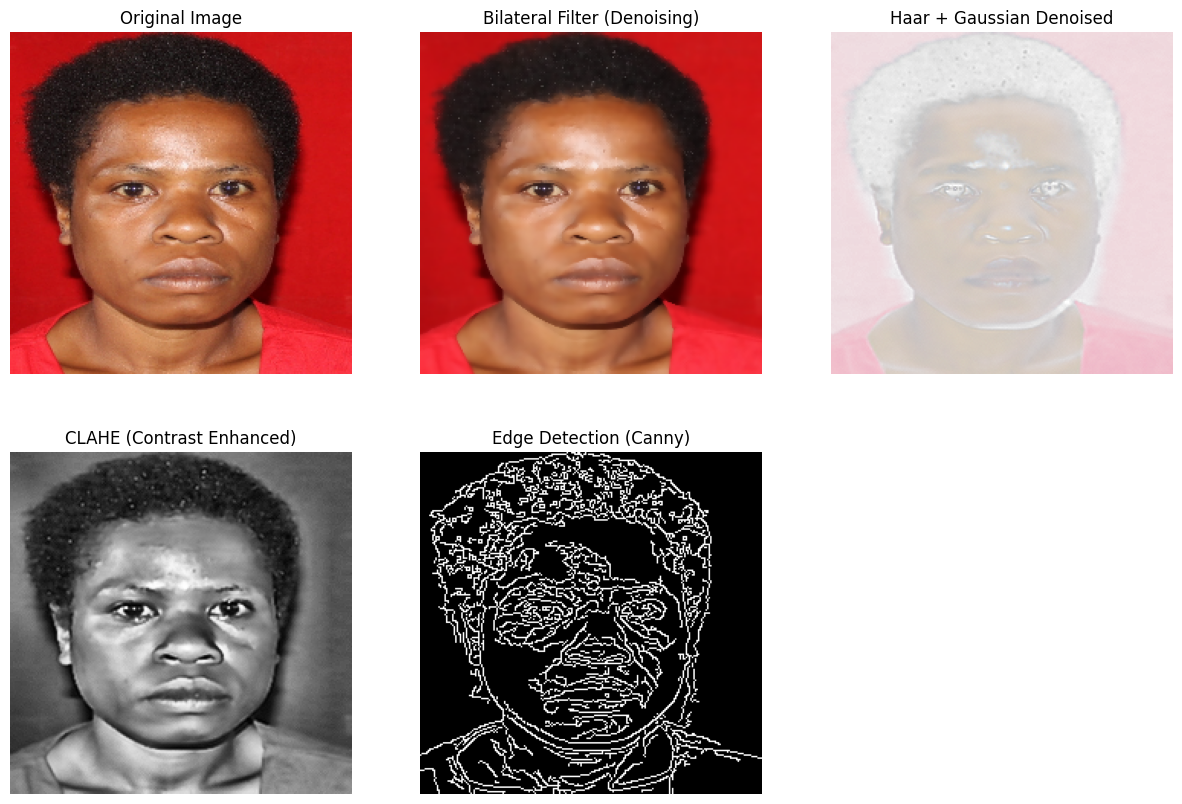

In [8]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# **Step 1: Resize Image**
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size, interpolation=cv2.INTER_CUBIC)

# **Step 2: Normalization using Z-score**
def z_score_normalization(image):
    mean, std = np.mean(image), np.std(image)
    norm_img = (image - mean) / (std + 1e-7)
    norm_img = (norm_img - np.min(norm_img)) / (np.max(norm_img) - np.min(norm_img)) * 255
    return norm_img.astype(np.uint8)

# **Step 3: Optimized Bilateral Filter**
def apply_bilateral_filter(image):
    return cv2.bilateralFilter(image, d=5, sigmaColor=50, sigmaSpace=50)  # Menjaga detail lebih baik

# **Step 4: Haar Wavelet Denoising + Optimized Gaussian Blur + Unsharp Masking**
def haar_wavelet_gaussian_denoising(image):
    coeffs2 = pywt.wavedec2(image, 'sym8', level=3)
    cA4, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs2

    def bayes_threshold(coeffs):
        sigma = np.median(np.abs(coeffs)) / 0.6745
        return max(sigma ** 1.8 / (np.mean(np.abs(coeffs)) + 1e-6), 0.012)  # **Lebih optimal**

    # Terapkan Thresholding yang lebih optimal
    detail_coeffs = [cH3, cV3, cD3, cH2, cV2, cD2, cH1, cV1, cD1]
    detail_coeffs = [np.sign(x) * np.maximum(np.abs(x) - bayes_threshold(x), 0) for x in detail_coeffs]

    # Rekonstruksi gambar setelah Haar Wavelet
    image_denoised = pywt.waverec2((cA4, tuple(detail_coeffs[:3]), tuple(detail_coeffs[3:6]), tuple(detail_coeffs[6:])), 'sym8')
    image_denoised = np.clip(image_denoised, 0, 255).astype(np.uint8)

    # **Gunakan Gaussian Blur yang lebih lembut (3,3) agar noise tetap berkurang tetapi detail tidak hilang**
    image_smooth = cv2.GaussianBlur(image_denoised, (3, 3), 0)

    # **Tambahkan Unsharp Masking untuk meningkatkan ketajaman gambar setelah Gaussian Blur**
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])  # Kernel sharpening sederhana
    image_sharpened = cv2.filter2D(image_smooth, -1, sharpening_kernel)

    return image_sharpened  # **Perbaikan: Kembalikan hasil setelah unsharp masking**

# **Step 5: Adaptive Histogram Equalization (CLAHE)**
def apply_clahe(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image).astype(np.uint8)

# **Step 6: Edge Detection using Canny Filter**
def edge_detection(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)  # Canny Edge Detection
    return edges.astype(np.uint8)

# **Step 7: Preprocessing Pipeline**
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 1️⃣ Resize
    image = resize_image(image)

    # 2️⃣ Normalization
    image = z_score_normalization(image)

    # 3️⃣ Bilateral Filter
    image_filtered = apply_bilateral_filter(image)

    # 4️⃣ Haar Wavelet + Gaussian Denoising
    image_denoised = haar_wavelet_gaussian_denoising(image_filtered)

    # 5️⃣ CLAHE (Enhance Contrast)
    image_clahe = apply_clahe(image_denoised)

    # 6️⃣ Edge Detection (Canny)
    image_edges = edge_detection(image_clahe)

    return (
        image.astype(np.uint8),
        image_filtered.astype(np.uint8),
        image_denoised.astype(np.uint8),
        image_clahe.astype(np.uint8),
        image_edges.astype(np.uint8),
    )

# **Fungsi untuk menghitung SSIM & PSNR**
def evaluate_image_quality(original, processed):
    if len(original.shape) == 3:
        original_gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    else:
        original_gray = original

    if len(processed.shape) == 3:
        processed_gray = cv2.cvtColor(processed, cv2.COLOR_RGB2GRAY)
    else:
        processed_gray = processed

    ssim_score = ssim(original_gray, processed_gray)
    psnr_score = cv2.PSNR(original_gray, processed_gray)

    return ssim_score, psnr_score

# **Contoh Penggunaan**
image_path = '/content/drive/MyDrive/WajahSorongRaya2/SorongSelatan/wugaje5309901001.jpg'
original, filtered, denoised, clahe, edges = preprocess_image(image_path)

# **Evaluasi gambar sebelum & sesudah preprocessing**
evaluations = {
    "Bilateral Filter": evaluate_image_quality(original, filtered),
    "Haar + Gaussian Denoising": evaluate_image_quality(original, denoised),
    "CLAHE (Contrast Enhanced)": evaluate_image_quality(original, clahe),
    "Edge Detection (Canny)": evaluate_image_quality(original, edges),
}

# **Tampilkan Hasil Evaluasi dengan Format yang Rapi**
print("\n=== Evaluasi Kualitas Gambar (SSIM & PSNR) ===")
print(f"{'Tahap Preprocessing':<35} {'SSIM':<10} {'PSNR (dB)':<10}")
print("-" * 60)
for step, (ssim_val, psnr_val) in evaluations.items():
    print(f"{step:<35} {ssim_val:<10.4f} {psnr_val:<10.2f}")
print("-" * 60)

# **Tampilkan Kategori Kualitas**
print("\n=== Kategori Kualitas Gambar ===")
header_kategori = "{:<20} {:<20} {:<15}".format("Kategori Kualitas", "Batas SSIM Minimum", "Batas PSNR Minimum")
print(header_kategori)
print("-" * len(header_kategori))

print("{:<25} {:<20} {:<15}".format("Sangat Baik ✅", "≥ 0.90", "≥ 30 dB"))
print("{:<25} {:<20} {:<15}".format("Dapat Diterima ⚠️", "≥ 0.75", "≥ 25 dB"))
print("{:<25} {:<20} {:<15}".format("Kurang Baik ❌", "< 0.75", "< 25 dB"))

print("-" * len(header_kategori))

print("=" * len(header_kategori))



# **Tampilkan Hasil Setiap Tahap**
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(original, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(filtered, cmap='gray')
plt.title("Bilateral Filter (Denoising)")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(denoised, cmap='gray')
plt.title("Haar + Gaussian Denoised")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(clahe, cmap='gray')
plt.title("CLAHE (Contrast Enhanced)")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection (Canny)")
plt.axis("off")

plt.show()


In [9]:
# Update train_df and test_df to preprocess images
def data_df(data_path):
    """
    Create a DataFrame for training data with preprocessing applied to each image.
    """
    classes = []
    class_paths = []
    preprocessed_images = []

    # Loop through each class directory and preprocess the images
    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        if os.path.isdir(label_path):  # Check if it is a directory
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                classes.append(label)
                class_paths.append(image_path)

                # Preprocess the image and store it
                processed_image = preprocess_image(image_path)
                preprocessed_images.append(processed_image)

    # Create a DataFrame with the preprocessed images and labels
    data = pd.DataFrame({'Class Path': class_paths, 'Class': classes, 'Processed Image': preprocessed_images})
    return data

In [10]:
# Generate the training and test DataFrames
data = data_df('/content/drive/MyDrive/WajahSorongRaya2')

In [11]:
data

Class Path    Class  \
0     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
1     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
2     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
3     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
4     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
...                                                 ...      ...   
1385  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   
1386  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   
1387  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   
1388  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   
1389  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   

                                        Processed Image  
0     ([[[114 158 175], [119 163 180], [119 162 180]...  
1     ([[[73 39 56], [65 32 50], [43 12 29], [38 11 ...  
2     ([[[211  40  80], [213  41  81], [214  42  82]...  
3     ([[[226 189 144], [231 194 148], [233 196 151]...  
4     ([[[252 215 151], [233 195 133], [203 166 107]...  
...                                                 ...  
1385  ([[[53 90 59], [40 77 48], [42 77 52], [52 86 ...  
1386  ([[[117 121 104], [116 120 105], [121 125 111]...  
1387  ([[[188 210 123], [190 209 125], [197 219 133]...  
1388  ([[[255 255 255], [255 255 255], [255 255 255]...  
1389  ([[[ 96 124  61], [106 137  70], [112 143  75]...  

[1390 rows x 3 columns]

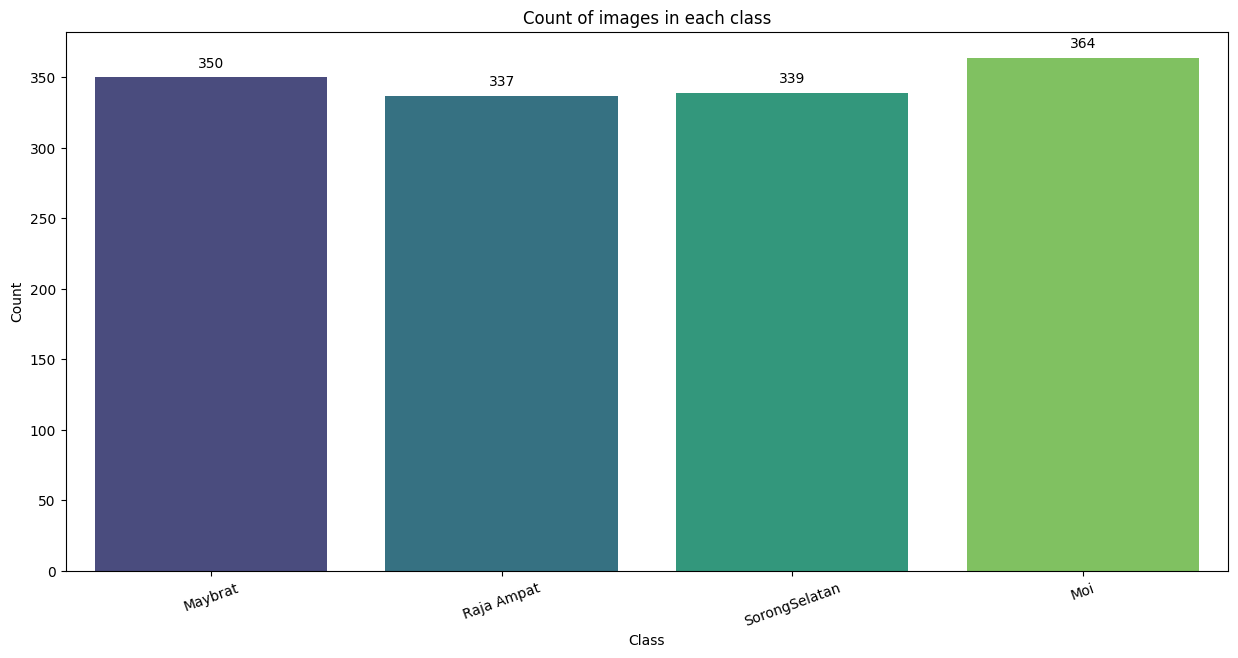

In [12]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(x=data['Class'], palette='viridis')
ax.set(xlabel='Class', ylabel='Count', title='Count of images in each class')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=5)
plt.xticks(rotation=20)
plt.show()

In [13]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Class'])

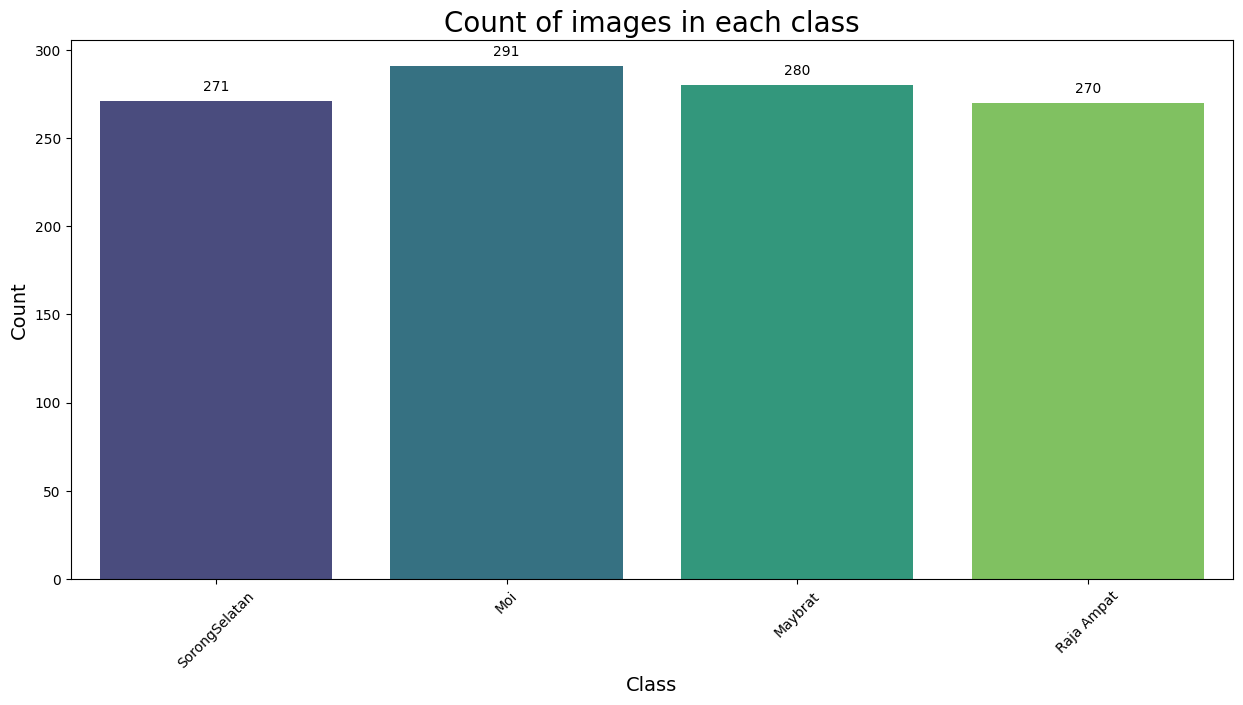

In [14]:
# Count of images in each class in train data
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=train_df, x=train_df['Class'], palette='viridis')  # Ubah 'y' menjadi 'x'
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of images in each class', fontsize=20)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=5)
plt.xticks(rotation=45)
plt.show()

In [15]:
train_df

Class Path          Class  \
914   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   
1371  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...            Moi   
867   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   
1180  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...            Moi   
255   /content/drive/MyDrive/WajahSorongRaya2/Maybra...        Maybrat   
...                                                 ...            ...   
595   /content/drive/MyDrive/WajahSorongRaya2/Raja A...     Raja Ampat   
10    /content/drive/MyDrive/WajahSorongRaya2/Maybra...        Maybrat   
2     /content/drive/MyDrive/WajahSorongRaya2/Maybra...        Maybrat   
381   /content/drive/MyDrive/WajahSorongRaya2/Raja A...     Raja Ampat   
745   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   

                                        Processed Image  
914   ([[[218  27  27], [219  29  28], [217  28  27]...  
1371  ([[[121 121 121], [116 116 116], [112 112 112]...  
867   ([[[245  59  65], [247  62  65], [245  60  62]...  
1180  ([[[119 124 143], [64 69 88], [57 62 81], [60 ...  
255   ([[[35 45 46], [39 49 51], [46 57 58], [41 52 ...  
...                                                 ...  
595   ([[[221 218 212], [222 219 213], [224 220 214]...  
10    ([[[71 75 85], [63 67 77], [59 64 71], [56 63 ...  
2     ([[[211  40  80], [213  41  81], [214  42  82]...  
381   ([[[236 224 186], [235 223 185], [234 222 184]...  
745   ([[[29 34 90], [34 40 99], [ 38  47 105], [20 ...  

[1112 rows x 3 columns]

In [16]:
test_df

Class Path          Class  \
1147  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...            Moi   
813   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   
347   /content/drive/MyDrive/WajahSorongRaya2/Maybra...        Maybrat   
1217  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...            Moi   
106   /content/drive/MyDrive/WajahSorongRaya2/Maybra...        Maybrat   
...                                                 ...            ...   
776   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   
418   /content/drive/MyDrive/WajahSorongRaya2/Raja A...     Raja Ampat   
415   /content/drive/MyDrive/WajahSorongRaya2/Raja A...     Raja Ampat   
697   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   
896   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   

                                        Processed Image  
1147  ([[[58 44 44], [61 48 48], [58 44 44], [71 58 ...  
813   ([[[ 90 124 179], [ 86 124 180], [ 82 121 176]...  
347   ([[[143 140 146], [139 137 143], [147 144 150]...  
1217  ([[[254 115 211], [251 122 216], [255 146 230]...  
106   ([[[26 25 32], [29 28 33], [29 29 32], [28 26 ...  
...                                                 ...  
776   ([[[252  92  97], [249  90  94], [253  99 101]...  
418   ([[[211 211 209], [222 222 220], [209 209 207]...  
415   ([[[228 204 169], [225 202 169], [226 203 170]...  
697   ([[[219  34  36], [218  32  35], [221  33  37]...  
896   ([[[2 1 0], [2 1 0], [2 1 0], [2 1 0], [1 1 1]...  

[278 rows x 3 columns]

In [17]:
batch_size = 32
img_size = (224, 224)
_gen = ImageDataGenerator(rescale=1/255,
 brightness_range=(0.7, 1.3))
ts_gen = ImageDataGenerator(rescale=1/255)
tr_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
 y_col='Class', batch_size=batch_size,
 target_size=img_size)
ts_gen = _gen.flow_from_dataframe(test_df, x_col='Class Path',
 y_col='Class', batch_size=16,
 target_size=img_size, shuffle=False)

Found 1112 validated image filenames belonging to 4 classes.
Found 278 validated image filenames belonging to 4 classes.


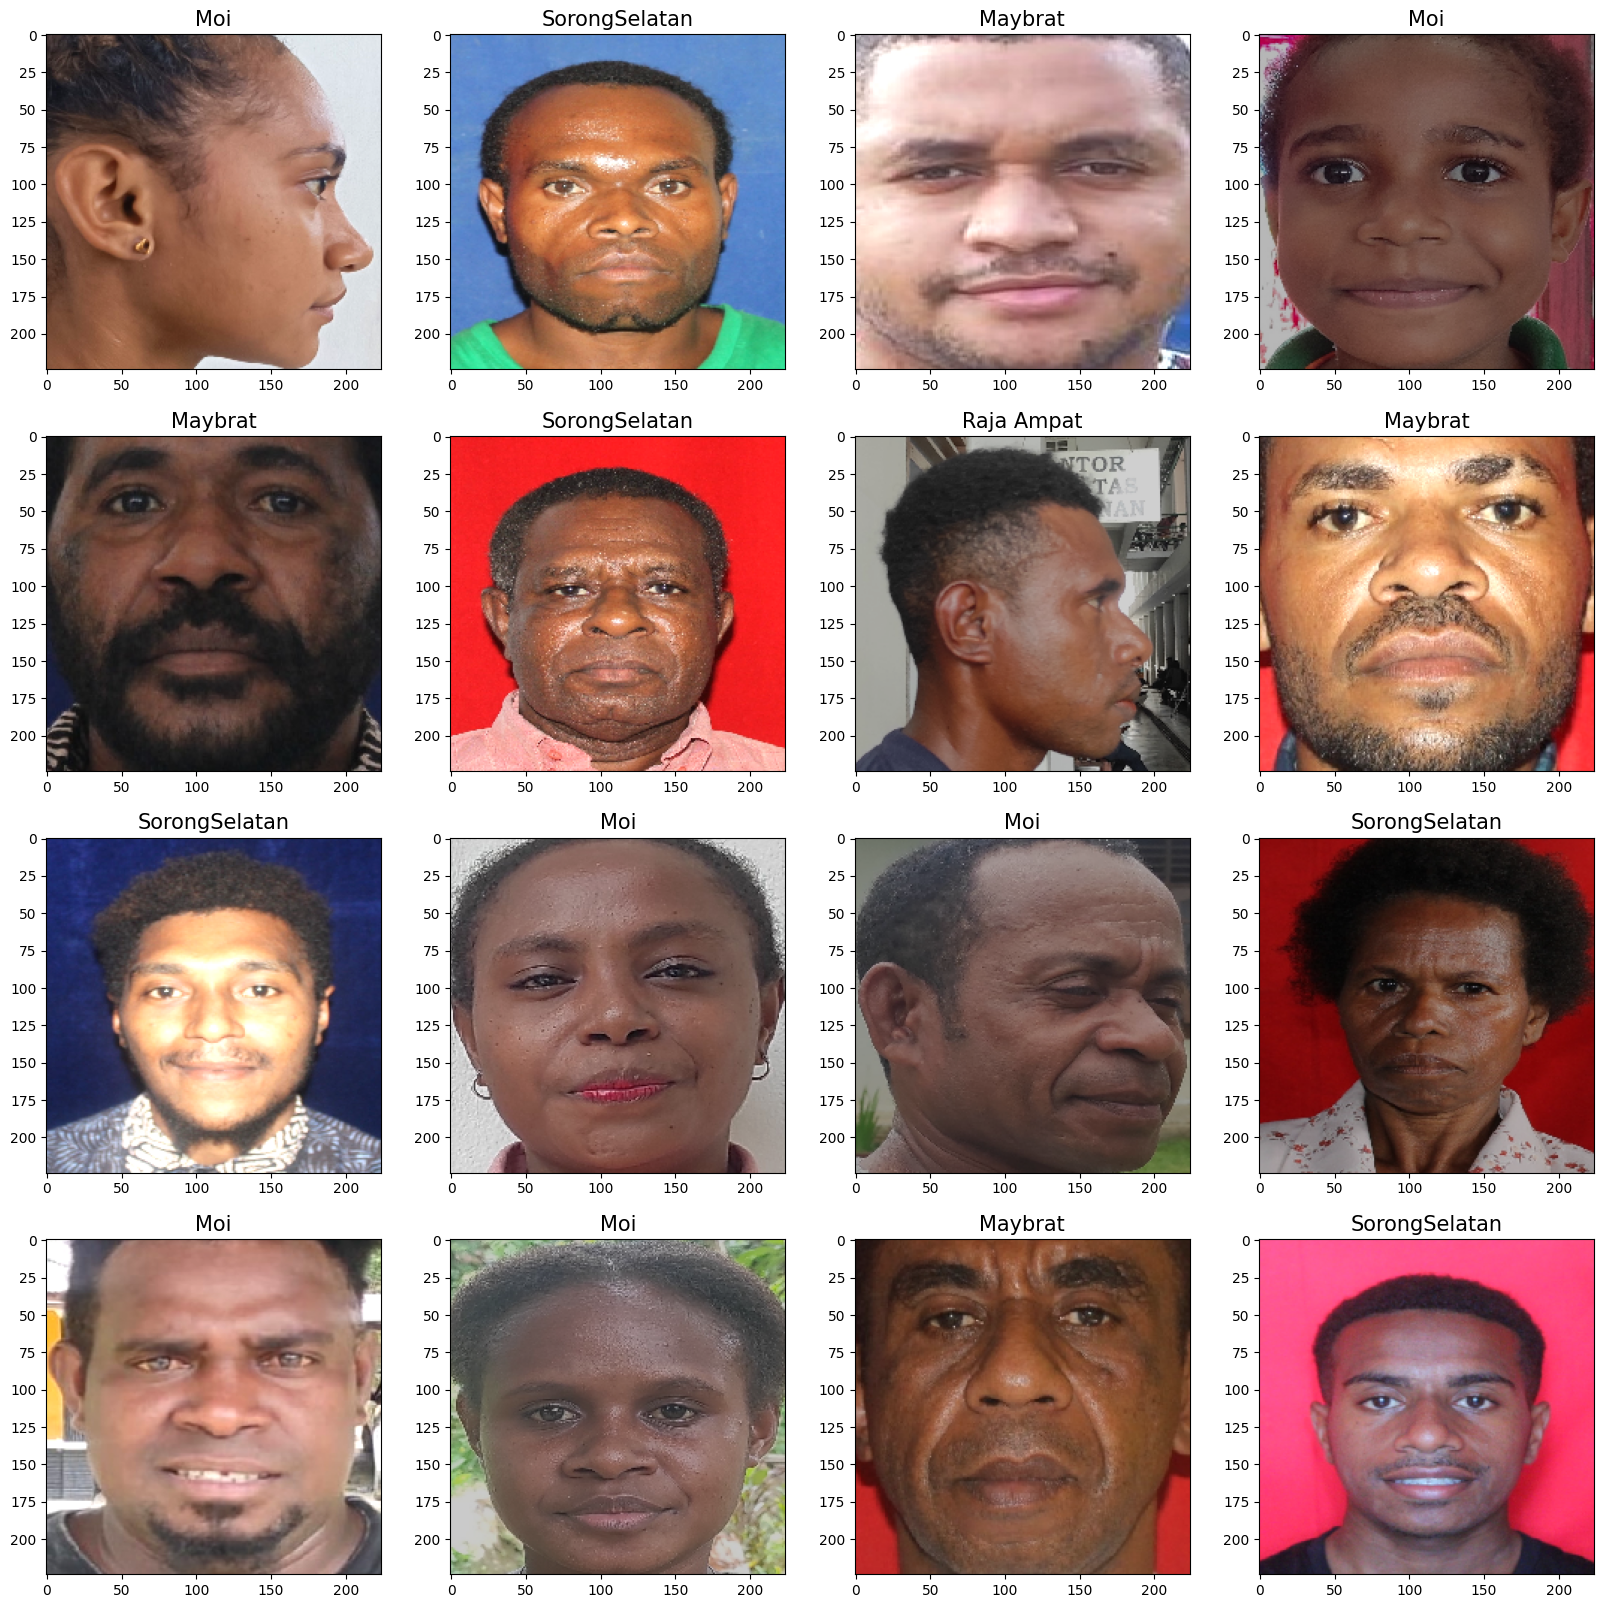

In [18]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)
plt.figure(figsize=(20, 20))
for i, (image, label) in enumerate(zip(images, labels)):
 plt.subplot(4,4, i + 1)
 plt.imshow(image)
 class_name = classes[np.argmax(label)]
 plt.title(class_name, color='k', fontsize=15)
plt.show()

In [19]:
#img_shape=(224,224,3)
#base_model = ResNet50(include_top=False, weights="imagenet",
#                     input_shape=img_shape, pooling='max')


#from tensorflow.keras.regularizers import l2
#from tensorflow.keras.layers import Dropout

#model = Sequential([
#    base_model,
#    Flatten(),
#    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
#    Dropout(0.4),
#    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
#    Dropout(0.3),
#    Dense(5
 #         , activation="softmax")
#])

#model.compile(optimizer=Adamax(learning_rate=0.0004),
#              loss='categorical_crossentropy',
#              metrics=['accuracy',
#                       Precision(name='precision'),
#                       Recall(name='recall')])


#model.summary()

SyntaxError: unmatched ']' (<ipython-input-19-117d84d75950>, line 18)

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2


# Ukuran input gambar
img_shape = (224, 224, 3)

# 1. Load pre-trained ResNet50 (tanpa top classifier, dengan bobot dari ImageNet)
base_model = ResNet50(include_top=False, weights='imagenet',
                      input_shape=img_shape, pooling='max')

# 2. Freeze semua layer awal untuk melindungi bobot ImageNet
base_model.trainable = False

# 3. Buat model baru di atas base_model
model = Sequential([
    base_model,
    Flatten(),  # Atau bisa diganti dengan GlobalAveragePooling2D()
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    #Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    #Dropout(0.3),
    #Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    #Dropout(0.3),
    Dense(4, activation='softmax')  # Output untuk klasifikasi 4 kelas
])

# 4. Kompilasi model
model.compile(
    optimizer=Adamax(learning_rate=0.0004),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# 5. Lihat ringkasan model
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,668 (92.11 MB)

 Trainable params: 557,956 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [22]:
hist = model.fit(tr_gen,
                 epochs=50,
                 validation_data=ts_gen,
                 shuffle= False)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 44s 478ms/step - accuracy: 0.3222 - loss: 6.2281 - precision: 0.3239 - recall: 0.2716 - val_accuracy: 0.2482 - val_loss: 1.9264 - val_precision: 1.0000 - val_recall: 0.0072
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.3797 - loss: 1.7387 - precision: 0.5729 - recall: 0.1671 - val_accuracy: 0.4101 - val_loss: 1.8117 - val_precision: 1.0000 - val_recall: 0.0144
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 429ms/step - accuracy: 0.4327 - loss: 1.7127 - precision: 0.5816 - recall: 0.1271 - val_accuracy: 0.4317 - val_loss: 1.6159 - val_precision: 1.0000 - val_recall: 0.1043
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 438ms/step - accuracy: 0.4681 - loss: 1.6462 - precision: 0.7035 - recall: 0.2177 - val_accuracy: 0.6043 - val_loss: 1.6191 - val_precision: 1.0000 - val_recall: 0.1331
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 440ms/step - accuracy: 0.5108 - loss: 1.6049 - precision: 0.6972 - recall: 0.2283 - val_accuracy: 0.6906 - val_los

In [23]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [24]:
tr_per = hist.history.get('precision', [])
val_per = hist.history.get('val_precision', [])

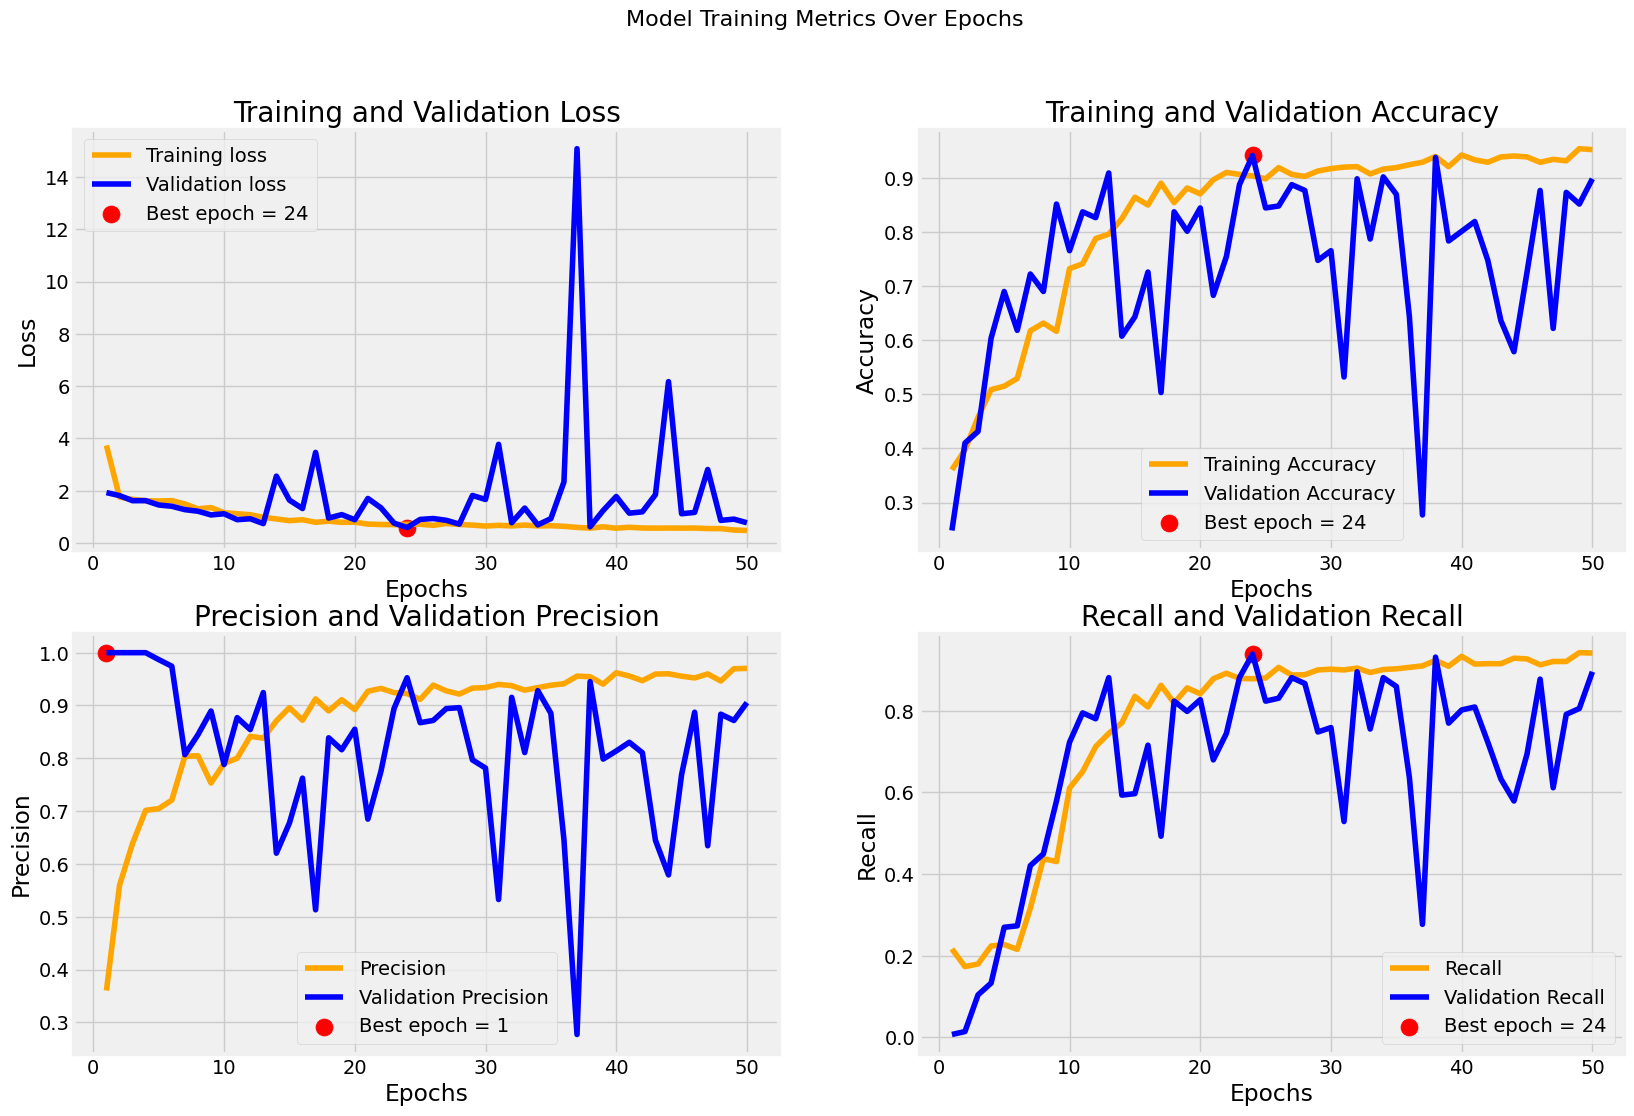

In [25]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label='Training loss')
plt.plot(Epochs, val_loss, 'blue', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='r', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'blue', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='r', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'orange', label='Precision')
plt.plot(Epochs, val_per, 'blue', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='r', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'orange', label='Recall')
plt.plot(Epochs, val_recall, 'blue', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='r', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [26]:
train_score = model.evaluate(tr_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.9364 - loss: 0.5886 - precision: 0.9378 - recall: 0.9296
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.9083 - loss: 0.7796 - precision: 0.9114 - recall: 0.8874
Train Loss: 0.5605
Train Accuracy: 94.42%
--------------------
Test Loss: 0.7659
Test Accuracy: 92.09%


In [27]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step


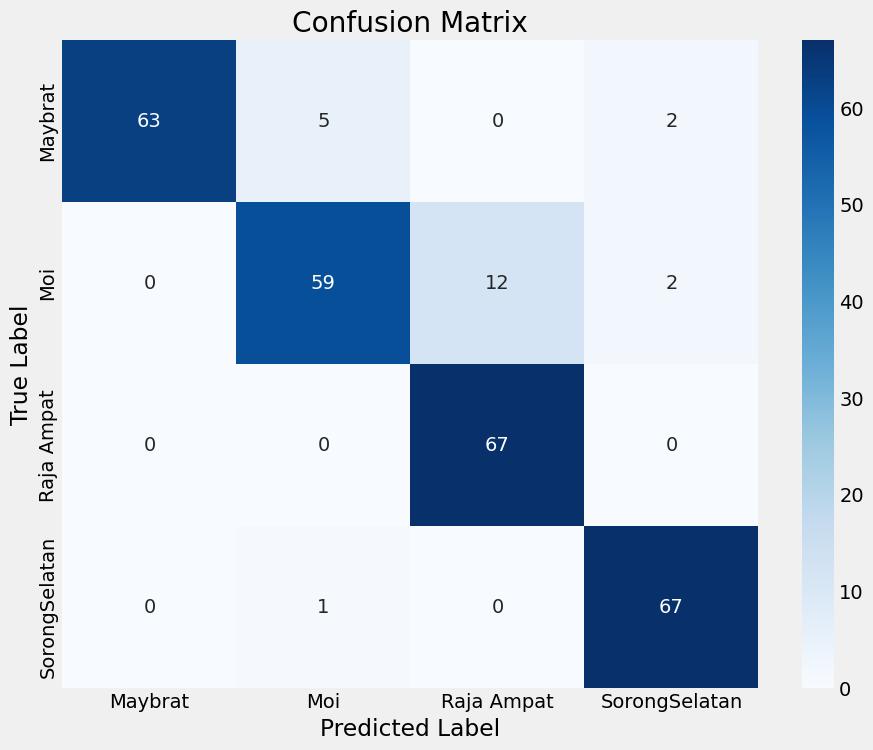

               precision    recall  f1-score   support

      Maybrat       1.00      0.90      0.95        70
          Moi       0.91      0.81      0.86        73
   Raja Ampat       0.85      1.00      0.92        67
SorongSelatan       0.94      0.99      0.96        68

     accuracy                           0.92       278
    macro avg       0.92      0.92      0.92       278
 weighted avg       0.93      0.92      0.92       278



In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ambil label kelas dari generator
labels = list(ts_gen.class_indices.keys())

# Konversi y_pred ke bentuk kelas jika masih dalam probabilitas
if y_pred.ndim > 1:  # Jika berbentuk (n_samples, n_classes)
    y_pred_classes = y_pred.argmax(axis=1)
else:
    y_pred_classes = y_pred  # Jika sudah berupa label langsung

# Buat confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Tampilkan classification report
clr = classification_report(ts_gen.classes, y_pred_classes, target_names=labels)
print(clr)

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

labels = ["Moi","Sorong Selatan", "Raja Ampat", "Maybrat"]

def predict(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    predictions = model.predict(img)
    probs = list(predictions[0])

    # Cek kesesuaian jumlah label dan probabilitas
    if len(probs) != len(labels):
        print(f"Error: The model produces {len(probs)} probability, but there is only {len(labels)} label!")
        return

    # Menampilkan gambar
    plt.figure(figsize=(6, 6))
    plt.subplot(2, 1, 1)
    plt.imshow(cv2.imread(img_path))
    plt.axis("off")
    plt.title("Input Image", fontsize=9)

    # Menampilkan hasil prediksi dalam bentuk bar chart
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs, color='skyblue')

    # Menambahkan teks akurasi di dalam balok
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                 f"{prob:.2%}", va='center', fontsize=9, color='black')

    plt.xlabel('Probability', fontsize=9)
    plt.xlim(0, 1)  # Set batas nilai x-axis dari 0 sampai 1
    plt.title("Prediction Confidence", fontsize=9)
    plt.show()

In [30]:
predict('/content/drive/MyDrive/WajahSorongRaya2/SorongSelatan/tahoba5602990004.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Error: The model produces 4 probability, but there is only 5 label!
